##  Jorney to BERT fine tunning

Мы будем использовать нашумевшую архитектуру BERT из `transformers` библиотеки для решения задачи классификации русских твитов.

Данный хранятся тут: https://study.mokoron.com/
это важный датасет для русского комьюнити, содержащие позитивные и негативные твиты на русском языке.

In [1]:
! pip install transformers

In [2]:
from IPython.display import clear_output

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Этот ноутбук можно выполнить даже с помощью только CPU. 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cpu'):
    print('Using cpu')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name(0)))

Using Tesla P100-PCIE-16GB GPUs


## Загрузка данных


Мы выбрали не очень известный, необычный датасет с разметкой сентимента русскоязычных твитов (подробнее про него в [статье](http://www.swsys.ru/index.php?page=article&id=3962&lang=)). В корпусе, который мы использовали 114,911 положительных и 111,923 отрицательных записей. Загрузить его можно [тут](https://study.mokoron.com/).

In [5]:
import pandas as pd

DIR_PATH = "./drive/My Drive/Colab Notebooks/"
pos_texts = pd.read_csv(DIR_PATH + 'positive.csv', encoding='utf8', sep=';', header=None)
neg_texts = pd.read_csv(DIR_PATH + 'negative.csv', encoding='utf8', sep=';', header=None)

In [ ]:
pos_texts.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11
74179,410631043063230465,1386737044,St_Almas,"RT @AminaSerzhanova: Ребята, ""пришли"" тюльпаны...",1,0,2,0,10789,3528,151,47
60159,410275930742218752,1386652379,alej_ramoni,RT @v_khabarov: @alej_ramoni спиженно;) у меня...,1,0,1,0,4209,31,10,0
38747,409888614345371648,1386560035,Varera_,В Киеве)\nхочу быстрее уже сдать все и уехать ...,1,0,0,0,3651,45,28,0
94099,410874909892816896,1386795186,nyuta_tracer,"понравилось,как реконструировали мак на октябр...",1,0,0,0,2482,29,20,0
66261,410382046498795520,1386677679,alwayswannakill,"@OksanaZavalii @nastyapanovaa ммм, очевидно, л...",1,0,0,0,311,15,37,0


Обратите внимание на специальные токены [CLS] и [SEP], которые мы добавляем в началои конец предложения.

In [ ]:
pos_texts[3].values

array(['@first_timee хоть я и школота, но поверь, у нас то же самое :D общество профилирующий предмет типа)',
       'Да, все-таки он немного похож на него. Но мой мальчик все равно лучше:D',
       'RT @KatiaCheh: Ну ты идиотка) я испугалась за тебя!!!', ...,
       'Что происходит со мной, когда в эфире #proactivefm звучит моя любимая песня)) #dctalk #music @… http://t.co/65KGFFd5oO',
       '"Любимая,я подарю тебе эту звезду..." Имя какой звезды переводится "подмышка"? ;-)',
       '@Ma_che_rie посмотри #непытайтесьпокинутьомск сегодня в Вавилоне в 18.20. Я там тоже есть :)'],
      dtype=object)

In [6]:
sentences = np.concatenate([pos_texts[3].values, neg_texts[3].values])

sentences = ['[CLS] ' + sentence + ' [SEP]' for sentence in sentences] # add tokens cls and sep for bert

# correct labels
labels = [[1] for _ in range(pos_texts.shape[0])] + [[0] for _ in range(neg_texts.shape[0])]


In [7]:
assert len(sentences) == len(labels) == pos_texts.shape[0] + neg_texts.shape[0]

In [8]:
print(sentences[100])
print(sentences[-100])

[CLS] @jolechka3 получается,осторожно котлетку перекладываю в др.посуду) [SEP]
[CLS] @LizHorbenko я по-тихоньку, у меня сессия в самом разгаре, ненавижу экономику, мат.анализ и естествознание ;( [SEP]


In [9]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)

In [10]:
print(len(train_gt), len(test_gt))

158783 68051


## Inputs

Теперь импортируем токенизатор для BERT'а, который превратит наши тексты в набор токенов, соответствующих тем, что встречаются в словаре предобученной модели.

In [ ]:
from transformers import BertTokenizer, BertConfig


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sentences) for sentences in train_sentences] # tokenize your sentences
print(tokenized_texts[0])

BERT'у нужно предоставить специальный формат входных данных.


- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из нулей и единиц. В нашем случае нули обозначают негативную эмоциональную окраску, единицы - положительную.
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

Паддинг нужен для того, чтобы BERT мог работать с предложениями разной длины. Выбираем максимально возможную длину предложения (в нашем случае пусть это будет 100). 

Теперь более длинные предложения будем обрезать до 100 токенов, а для более коротких использовать паддинг. Возьмем готовую функцию `pad_sequences` из библиотеки `keras`.



In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# padding
input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)

attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

Делим данные на `train` и `val`:

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

Преобразуем данные в `pytorch` тензоры:

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [ ]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [ ]:
train_labels

tensor([[0],
        [1],
        [1],
        ...,
        [0],
        [0],
        [1]])

Воспользуемся классом `DataLoader`. Это поможет нам использовать эффективнее память во время тренировки модели, так как нам не нужно будет загружать в память весь датасет. Данные по батчам будем разбивать произвольно с помощью RandomSampler. Также обратите внимание на размер батча: если во время тренировки возникнет `Memory Error`, размер батча необходимо уменьшить.

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=32)

In [ ]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(validation_data, sampler=SequentialSampler(validation_data), batch_size=32)

## Обучение модели

Теперь когда данные подготовлены, надо написать пайплайн обучения модели.

Для начала мы хотим изменить предобученный BERT так, чтобы он выдавал метки для классификации текстов, а затем файнтюнить его на наших данных. Мы возьмем готовую модификацию BERTа для классификации из pytorch-transformers. Она интуитивно понятно называется `BertForSequenceClassification`. Это обычный BERT с добавленным линейным слоем для классификации.

Загружаем [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129):

In [ ]:
from transformers import AdamW, BertForSequenceClassification

Аналогичные модели есть и для других задач. Все они построены на основе одной и той же архитектуры и различаются только верхними слоями.

In [ ]:
from transformers import BertForQuestionAnswering, BertForTokenClassification

Теперь подробнее рассмотрим процесс файн-тюнинга. Как мы помним, первый токен в каждом предложении - это `[CLS]`. В отличие от скрытого состояния, относящего к обычному слову (не метке `[CLS]`), скрытое состояние относящееся к этой метке должно содержать в себе аггрегированное представление всего предложения, которое дальше будет использоваться для классификации. Таким образом, когда мы скормили предложение в процессе обучения сети, выходом будет вектор со скрытым состоянием, относящийся к метке `[CLS]`. Дополнительный полносвязный слой, который мы добавили, имеет размер `[hidden_state, количество_классов]`, в нашем случае количество классов равно двум. То есть нав выходе мы получим два числа, представляющих классы "положительная эмоциональная окраска" и "отрицательная эмоциональная окраска".

Процесс дообучения достаточно дешев. По факту мы тренируем наш верхний слой и немного меняем веса во всех остальных слоях в процессе, чтобы подстроиться под нашу задачу.

Иногда некоторые слои специально "замораживают" или применяют разные стратегии работы с learning rate, в общем, делают все, чтобы сохранить "хорошие" веса в нижних слоях и ускорить дообучение. В целом, замораживание слоев BERTа обычно не сильно сказывается на итоговом качестве, однако надо помнить о тех случаях, когда данные, использованные для предобучения и дообучения очень разные (разные домены или стиль: академическая и разговорная лексика). В таких случаях лучше тренировать все слои сети, не замораживая ничего.

Загружаем BERT. `bert-base-uncased` - это версия "base" (в оригинальной статье рассказывается про две модели: "base" vs "large"), где есть только буквы в нижнем регистре ("uncased").

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)
print(1)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

1


### Обучение
Теперь обсудим гиперпараметры для обучения нашей модели. Авторы статьи советуют выбирать `learning rate` `5e-5`, `3e-5`, `2e-5`, а количество эпох не делать слишком большим, 2-4 вполне достаточно. Мы пойдем еще дальше и попробуем дообучить нашу модель всего за одну эпоху.

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

In [ ]:
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()


for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels, token_type_ids=None)
    
    train_loss_set.append(loss[0].item())
    # Backward pass
    loss[0].backward()
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()
    # Обновляем loss
    train_loss += loss[0].item()
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()

    if step == 1000:
      break
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))


# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, attention_mask=b_input_mask, token_type_ids=None)
    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

    print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
        accuracy_score(valid_labels, valid_preds) * 100
    ))



In [ ]:
print("Результат: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Результат: 98.09%


## Оценка качества на отложенной выборке

Качество на валидационной выборке оказалось очень хорошим. Не переобучилась ли наша модель?

Делаем точно такую же предобработку для тестовых данных, как и в начале ноутбука делали для обучающих данных:

In [ ]:
tokenized_texts = [tokenizer.tokenize(sentences) for sentences in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)

Создаем attention маски и приводим данные в необходимый формат:

In [ ]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=32
)

In [ ]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, attention_mask=b_input_mask, token_type_ids=None)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

In [ ]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 98.06%


In [ ]:
print('Неправильных предсказаний: {0}/{1}'.format(
    sum([0 if val == test_preds[idx] else 1 for idx, val in enumerate(test_labels)]),
    len(test_labels)
))

Неправильных предсказаний: 1318/68051


### Оценка качества работы без fine-tuning

In [ ]:
model_wo_finetuning = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model_wo_finetuning.cuda()

In [ ]:
model_wo_finetuning.eval()
preds_wo_finetuning, labels_wo_finetuning = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model_wo_finetuning(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    preds_wo_finetuning.extend(batch_preds)
    labels_wo_finetuning.extend(batch_labels)

In [ ]:
acc_score_wo_finetuning = accuracy_score(labels_wo_finetuning, preds_wo_finetuning)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score_wo_finetuning*100
))

Процент правильных предсказаний на отложенной выборке составил: 50.53%


Сравним точность и полноту предсказаний:

In [ ]:
from sklearn.metrics import recall_score, precision_score

print('1 эпоха: точность (precision) {0:.2f}%, полнота (recall) {1:.2f}%'.format(
    precision_score(test_labels, test_preds) * 100,
    recall_score(test_labels, test_preds) * 100
))
 
print('Без дообучения: точность (precision) {0:.2f}%, полнота (recall) {1:.2f}%'.format(
    precision_score(labels_wo_finetuning, preds_wo_finetuning) * 100,
    recall_score(labels_wo_finetuning, preds_wo_finetuning) * 100,
))

1 эпоха: точность (precision) 99.74%, полнота (recall) 96.43%
Без дообучения: точность (precision) 50.59%, полнота (recall) 98.79%


## Итог 

Здесь мы показали, что предобученный BERT может быстро (всего за одну эпоху) давать хорошее качество при решении задачи анализа эмоциональной окраски текстов. Обратите внимание, что мы не тюнили параметры и использовали сравнительно небольшой размеченный корпус, чтобы получить accuracy больше 98\%. Тем не менее, если не делать дообучения под конкретную задачу вовсе, получить хорошее качество не удается.

Кроме того, мы познакомились с библиотекой `transformers`, которая позволяет использовать готовые обертки над моделями, специально созданными для решения той или иной задачи. Использовать BERT при решении повседневных NLP задач совсем нетрудно: не нужно даже вручную скачивать веса модели, библиотека все сделает за вас. Отбросив необходимость чуть-чуть предобработать тексты, сложность применения предобученного BERT'а оказывается не сильно больше, чем импортировать и применить лог.регрессию из `sklearn`.

### Домашнее задание
В данный момент улучшениями над бертом являются следующие модели: XLNet и RoBERTA, причем вторая это просто качественнее тренированная модель. Также на лекции мы рассмотрели облегченный вариант берта - AlBERT. 

А давайте проверим, как они работают в нашем случае при finetunnig. Поставьте эксперимент и сравните работу четырех моделей:
* Bert (с семинара)
* XLNet
* RoBERTa
* AlBERT


**Задание 1:**
Постройте график (качество на валидации по оси y, количество шагов обучения или эпох по оси x) с четырьмя кривыми и сделайте выводы о том какая модель работает лучше.

**Задание 2:**
Сравните количество параметров для всех четырех моделей.

In [27]:
from transformers import XLNetForSequenceClassification, XLNetTokenizer
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from transformers import AlbertForSequenceClassification, AlbertTokenizer
from transformers import BertForSequenceClassification, BertTokenizer

In [17]:
def get_dataloaders(input_data, input_labels, tokenizer):
    train_sentences, test_sentences, train_gt, test_gt = train_test_split(input_data, input_labels, test_size=0.3)
    tokenized_texts = [tokenizer.tokenize(sentences) for sentences in train_sentences] # tokenize your sentences
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

    # padding
    input_ids = pad_sequences(
        input_ids,
        maxlen=100,
        dtype="long",
        truncating="post",
        padding="post"
    )
    attention_masks = [[float(i>0) for i in seq] for seq in input_ids]
    train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
        input_ids, train_gt, 
        random_state=42,
        test_size=0.1
    )
    train_masks, validation_masks, _, _ = train_test_split(
        attention_masks,
        input_ids,
        random_state=42,
        test_size=0.1
    )
    train_inputs = torch.tensor(train_inputs)
    train_labels = torch.tensor(train_labels)
    train_masks = torch.tensor(train_masks)
    validation_inputs = torch.tensor(validation_inputs)
    validation_labels = torch.tensor(validation_labels)
    validation_masks = torch.tensor(validation_masks)
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=32)
    validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_dataloader = DataLoader(validation_data, sampler=SequentialSampler(validation_data), batch_size=32)

    return train_dataloader, validation_dataloader


def calc_model_info(model, train_dataloader, validation_dataloader, device, steps):

    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.0}
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

    # Будем сохранять loss во время обучения
    # и рисовать график в режиме реального времени
    train_loss_set = []
    train_loss = 0


    # Обучение
    # Переводим модель в training mode
    model.train()

    for step, batch in enumerate(train_dataloader):
        # добавляем батч для вычисления на GPU
        batch = tuple(t.to(device) for t in batch)
        # Распаковываем данные из dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # если не сделать .zero_grad(), градиенты будут накапливаться
        optimizer.zero_grad()
        # Forward pass
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels, token_type_ids=None)
        
        train_loss_set.append(loss[0].item())
        # Backward pass
        loss[0].backward()
        # Обновляем параметры и делаем шаг используя посчитанные градиенты
        optimizer.step()
        # Обновляем loss
        train_loss += loss[0].item()
        # Рисуем график
        clear_output(True)
        plt.plot(train_loss_set)
        plt.title("Training loss")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.show()

        if step == steps:
          break
        

    # Валидация
    # Переводим модель в evaluation mode
    model.eval()

    valid_preds, valid_labels = [], []

    for batch in validation_dataloader:   
        # добавляем батч для вычисления на GPU
        batch = tuple(t.to(device) for t in batch)
        # Распаковываем данные из dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # При использовании .no_grad() модель не будет считать и хранить градиенты.
        # Это ускорит процесс предсказания меток для валидационных данных.
        with torch.no_grad():
            logits = model(b_input_ids, attention_mask=b_input_mask, token_type_ids=None)
        # Перемещаем logits и метки классов на CPU для дальнейшей работы
        logits = logits[0].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        batch_preds = np.argmax(logits, axis=1)
        batch_labels = np.concatenate(label_ids)     
        valid_preds.extend(batch_preds)
        valid_labels.extend(batch_labels)

    return accuracy_score(valid_labels, valid_preds) * 100
    # return train_loss_set, valid_preds, valid_labels, param_optimizer


In [13]:
EPOCH_C = [1, 10, 50, 100, 150, 200, 250]

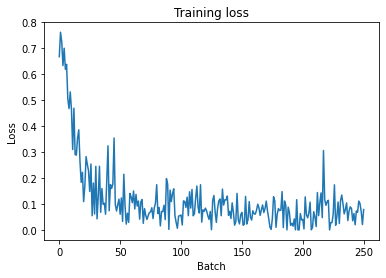

In [18]:
#XLNET
xln_acc_by_epoch = []
xln_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)
train_dataloader, validation_dataloader = get_dataloaders(sentences, labels, xln_tokenizer)

for steps in EPOCH_C:
    xln_model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased')
    xln_model.to(device)
    xln_val_acc = calc_model_info(xln_model, train_dataloader, validation_dataloader, device, steps)
    xln_acc_by_epoch.append(xln_val_acc)

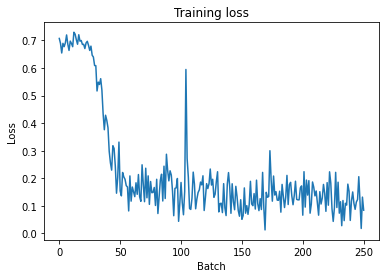

In [19]:
#ROBERTA
rbt_acc_by_epoch = []
rbt_tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)
train_dataloader, validation_dataloader = get_dataloaders(sentences, labels, rbt_tokenizer)

for steps in EPOCH_C:
    rbt_model = RobertaForSequenceClassification.from_pretrained('roberta-base')
    rbt_model.to(device)
    rbt_val_acc = calc_model_info(rbt_model, train_dataloader, validation_dataloader, device, steps)
    rbt_acc_by_epoch.append(rbt_val_acc)

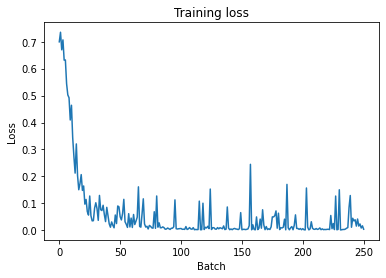

In [21]:
#ALBERT
alb_acc_by_epoch = []
alb_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)
train_dataloader, validation_dataloader = get_dataloaders(sentences, labels, alb_tokenizer)

for steps in EPOCH_C:
    alb_model = AlbertForSequenceClassification.from_pretrained('albert-base-v2')
    alb_model.to(device)
    alb_val_acc = calc_model_info(alb_model, train_dataloader, validation_dataloader, device, steps)
    alb_acc_by_epoch.append(alb_val_acc)

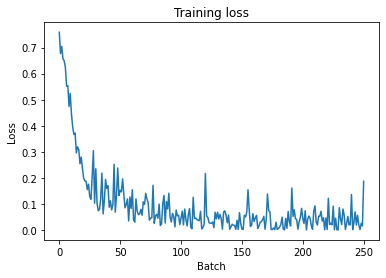

In [28]:
brt_acc_by_epoch = []
brt_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
train_dataloader, validation_dataloader = get_dataloaders(sentences, labels, brt_tokenizer)

for steps in EPOCH_C:
    brt_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
    brt_model.to(device)
    brt_val_acc = calc_model_info(brt_model, train_dataloader, validation_dataloader, device, steps)
    brt_acc_by_epoch.append(brt_val_acc)

1. Постройте график (качество на валидации по оси y, количество шагов обучения или эпох по оси x) с четырьмя кривыми и сделайте выводы о том какая модель работает лучше.

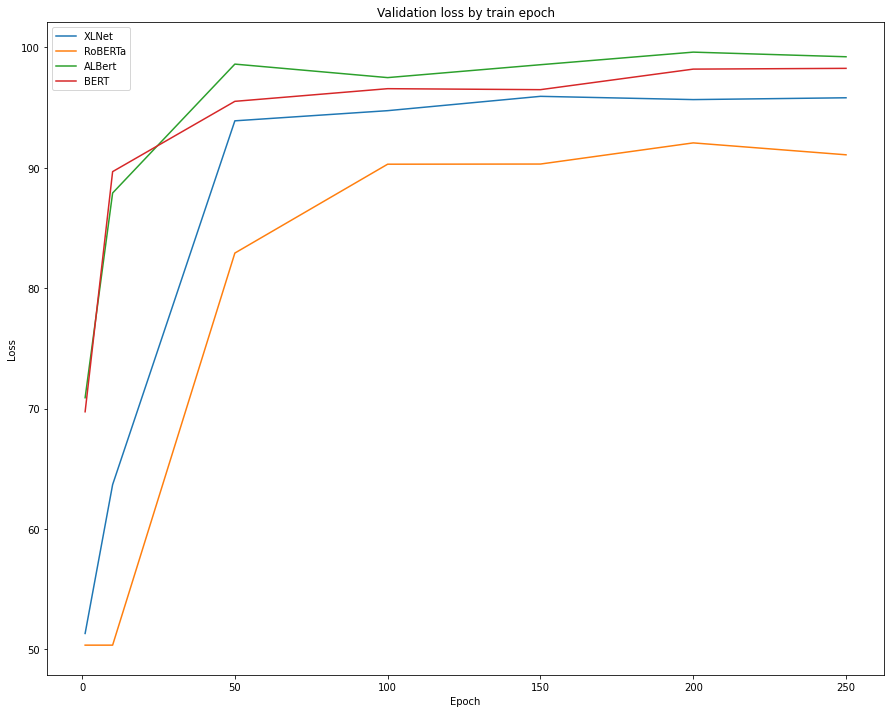

In [29]:
plt.figure(figsize=(15, 12))
plt.plot(EPOCH_C, xln_acc_by_epoch, label='XLNet')
plt.plot(EPOCH_C, rbt_acc_by_epoch, label='RoBERTa')
plt.plot(EPOCH_C, alb_acc_by_epoch, label='ALBert')
plt.plot(EPOCH_C, brt_acc_by_epoch, label='BERT')
plt.title("Validation loss by train epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Задание 2: Сравните количество параметров для всех четырех моделей.

In [44]:
params_len = {
    "ALBERT": len([p for p in alb_model.named_parameters()]),
    "BERT": len([p for p in brt_model.named_parameters()]),
    "RoBERTa": len([p for p in rbt_model.named_parameters()]),
    "XLNet": len([p for p in xln_model.named_parameters()]),
}
print(params_len)

{'ALBERT': 27, 'BERT': 201, 'RoBERTa': 203, 'XLNet': 210}
